In [1]:

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#from statistics import mean
#from scipy import integrate
#from scipy.signal import lfilter
from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
#import statistics
#import copy
from pandas import *

In [2]:
# this file makes 1 figure in current paper:
#   rescale3.png 
#       showing peak velocities as a function of distance from impact point and for 3 different impact angles
#       showing how to reduce scatter by rescaling. 

# required datasets: t36c.csv -- t86c.csv and t36f.csv -- t86f.csv taken June/July 2023

In [3]:
## acc voltage to real units m/s^2 conversion factors (calibration facs)
## [y1,x1,z1, y2,x2,z2] acc channels
cal_F2F3 = [0.00601427, 0.0059633, 0.0059633, 0.00606523, 0.00606523, 0.0059633] # +-16g
cal_F5F7  = [0.0328, 0.0325, 0.0322, 0.0324, 0.0328, 0.0327]  # +-3g
cal_F1F2 = [0.006473,0.006116,0.0062181,0.00601427,0.006014271,0.006014271]  # +-16g

In [4]:
dt = 1/2e5 # in seconds  -- from 200 kHz sampling rate
dt_ms = dt*1e3
datadir = './acc_data/junejuly_23/'
v_imp = 104.0  # impact velocity  m/s
rho_s = 1500.  # sand density kg/m^3
M_p = 0.20*1e-3 # g to kg projectile mass
K_imp = 0.5*M_p*v_imp**2  #kinetic energy of projectile
R_cr_cm = 3.5 #cm
R_cr = R_cr_cm*1e-2 # cm to m
k_seis = 1e-3
B_eff = 1.0
#Scaling factors
v_pk_Cr_E = np.sqrt(k_seis*K_imp/(2*np.pi*R_cr**3*rho_s))  #eqn 49 by Q+22
v_pk_Cr_P = B_eff*M_p*v_imp/(rho_s*2*np.pi*R_cr**3)  #Eqn 50 by Q+22
print('v_pk= {:.3f} vp_k = {:.3f} m/s'.format(v_pk_Cr_E,v_pk_Cr_P ))

v_pk= 0.052 vp_k = 0.051 m/s


In [5]:
#dpx is change in x momentum of projectile in units of momentum of projectile
#dpz is change in z momentum of projectile in units of momentum of projectile
#Ep is fraction of kinetic energy lost by projectile in units of KE of projectile 
# these are from laser_line_synth.ipynb
# here in order of increasing theta_I in increments of 10 degrees
theta_I_list = np.linspace(10,80,8)
# fraction of motion transferred to medium
dpx = np.array([0.19885541, 0.51451918, 0.58174439, 0.69982337, 0.6352634,  0.5, 0.34202014 ,0.17364818])
dpz= np.array([0.31223278, 0.46393667, 0.58963346, 0.67799798, 0.76764376, 0.8660254,0.93969262, 0.98480775])
# fraction of KE from projectile lost to medium
dEp = np.array([0.36307322, 0.80436391, 0.91115015, 0.994375 ,  0.99994083, 1., 1. ,  1.       ])
P0 = v_imp*M_p
P0_x = P0*np.cos(theta_I_list*np.pi/180)  # components of initial momentum 
P0_z = P0*np.sin(theta_I_list*np.pi/180)
P_x = P0*dpx  # momentum lost to medium
P_z = P0*dpz
E_imp = K_imp*dEp

In [6]:
# read in csv file output by oscilloscope
# cal is a calibration file for 6 accelerometer channels
# t_impact is estimate for time of impact in ms
# first_second is 0 or 1 depending upon whether you want the first accelerometer or the second
# the resulting data arrays only contain 3 axes of a single accelerometer

ilen = 3000  # how many data samples I am going to store!
def read_data(file_name,cal,t_impact,first_second):
    data_array = np.zeros([4,ilen])
    col = ['Time', 'Channel A', 'Channel B', 'Channel C','Channel E','Channel F','Channel G'] # defined columns
    col_list = [0,1,2,3,4,5,6]
    data_pd = pd.read_csv(file_name, usecols = col_list,dtype=float,skiprows=[1])   # array in pandas
    # time array is supposed to be in seconds
    data_pd['Time']*= 1000.0  # time now in ms
    data_pd['Time'] -= t_impact
    i0 = np.argmin(np.abs(data_pd['Time']+3))  # 3 ms prior to impact 
    mmarr = np.zeros(6)
    for i in range(1,7):
        data_pd[col[i]]/= cal[i-1]  # calibrate to m/s^2
        mm = np.median(data_pd[col[i]])
        #data_pd[col[i]]-= mm  #median not subtracted here!!!! 
        mmarr[i-1] = mm
    #print(mmarr)
    data_array[0,:] = np.array(data_pd['Time'][i0:i0+ilen])
    if (first_second==0):
        for i in range(1,4):
            data_array[i,:] = data_pd[col[i]][i0:i0+ilen]  #limit size of arrays in time 
    else: 
        for i in range(1,4):
            data_array[i,:] = data_pd[col[i+3]][i0:i0+ilen]  #limit size of arrays
    return data_pd, data_array

In [7]:
# read in all data into cubes, not necessarily all at one radius/depth,  including uprange downrange
# single cal file!
def read_data_set(datadir,cal,dfilelist,t_impact_list):
    n_theta_I = len(t_impact_list)
    data_cube_uprange   = np.zeros([n_theta_I,4,ilen])
    data_cube_downrange = np.zeros([n_theta_I,4,ilen])
    for i in range(n_theta_I):
        filename = datadir + dfilelist[i]
        t_impact=t_impact_list[i]
        data_pd0,data_array0 = read_data(filename,cal,t_impact,0)  # downrange
        data_pd1,data_array1 = read_data(filename,cal,t_impact,1)  # uprange
        #print(data_array.shape)
        for j in range(4):
            data_cube_uprange[i,j,:]  = np.squeeze(data_array1[j,:])
            data_cube_downrange[i,j,:]  = np.squeeze(data_array0[j,:])
    return data_cube_uprange,data_cube_downrange
# put data in cubes!

def rot_xy(x,y,phi):
    xp = np.cos(phi)*x + np.sin(phi)*y
    yp = np.sin(phi)*x - np.cos(phi)*y
    return xp,yp

# trying to correct rotation in R vs t (xy axes of accelerometer)
def corr_rot(data_cube):
    new_data_cube = np.copy(data_cube)
    nt = data_cube.shape[0]
    alin = np.linspace(-0.3,0.3,30)
    dist = alin*0
    tarr = np.squeeze(data_cube[0,0,:])
    for i in range(nt):
        a_R = np.squeeze(data_cube[i,2,:])
        a_z = np.squeeze(data_cube[i,1,:])
        a_t = np.squeeze(data_cube[i,3,:])
        for j in range(len(alin)):
            a_R_new,a_t_new = rot_xy(a_R,a_t,alin[j])
            dist[j] = np.sum(a_t_new**2) 
        jj = np.argmin(dist)
        a_R_new,a_t_new = rot_xy(a_R,a_t,alin[jj])
        new_data_cube[i,2,:]= a_R_new
        new_data_cube[i,3,:]= a_t_new
        print(alin[jj])
        #plt.plot(tarr,a_R_new)
        #plt.plot(tarr,a_t_new)
    return new_data_cube
            
        

In [12]:
# do integration to create velocity signals from acceleration signals
# here dt is sampling spacing in time

corr_rot_Bool = 0  #if 1 try correcting rotation if 0 don't
# this really made no different to plot, but I checked to make sure!

def mkvels(data_cube,dt):
    adata = np.copy(data_cube)  # medianed accel data cube
    vdata = adata*0  # velocity cube
    nt = data_cube.shape[0]
    new_adata = np.copy(adata)
    for i in range(nt):   # loop over impact angles 
        tarr = np.squeeze(data_cube[i,0,:])
        i0 = np.argmin(np.abs(tarr))
        vdata[i,0,:] = tarr # copy time arrays over to velocity cube
        # subtract off median prior to impact
        for j in range(1,4):  # loop over three axes
            mm = np.mean(data_cube[i,j,0:i0])
            adata[i,j,:] = data_cube[i,j,:] - mm
    if (corr_rot_Bool ==1):
        new_adata = corr_rot(adata)  # correct via rotation?
    else:
        new_adata = adata
    
    # integrate velocity
    for i in range(nt):
        for j in range(1,4):
            data = np.squeeze(new_adata[i,j,:])
            vdata[i,j,:] = np.cumsum(data)*dt
    return new_adata,vdata 
    # returns both accelerations and velocities 



In [9]:
# compute the velocity magnitude given index of impact angle
# also compute the angle of the velocity vector as a function of time
# this routine could be run on acceleration cube instead of velocity cube
def umag(cube,theta_i):
    uz = np.squeeze(cube[theta_i,1,:])
    uR = np.squeeze(cube[theta_i,2,:])
    ut = np.squeeze(cube[theta_i,3,:])
    theta = np.arctan2(uz,uR)  # computes spherical coordinate angle?
    um = np.sqrt(uR**2 + uz**2 + ut**2)  # magnitude of velocity 
    return um,theta
# returns magnitude of velocity or acceleration (depending upon cube) for a particular impact angle

# to find velocity component we need to know positions of accelerometers R,z
def ur_cube(cube,theta_i,R,z):
    uz = np.squeeze(cube[theta_i,1,:])
    uR = np.squeeze(cube[theta_i,2,:])
    ut = np.squeeze(cube[theta_i,3,:])
    r = np.sqrt(R**2 + z**2)
    rhat_x = R/r; rhat_z = z/r
    u_r = uR*rhat_x + uz*rhat_z  # spherical coordinates radial component 
    return u_r

def find_peaks_angles(upcube,downcube,R,z):
    nt = upcube.shape[0]
    u_up   = np.zeros(nt)
    u_down = np.zeros(nt)
    theta_up   = np.zeros(nt)
    theta_down = np.zeros(nt)
    ur_up = np.zeros(nt)
    ur_down = np.zeros(nt)
    for i in range(nt):
        u, theta = umag(upcube,i)
        imax = np.argmax(u)
        u_up[i] = u[imax]
        theta_up[i] = theta[imax]
        u, theta = umag(downcube,i)
        imax = np.argmax(u)
        u_down[i] = u[imax]
        theta_down[i] = theta[imax]
    if (np.isscalar(R)) :
        for i in range(nt):
            u_r = ur_cube(upcube,i,R,z)
            imax = np.argmax(u_r)
            ur_up[i] = u_r[imax]
            u_r = ur_cube(downcube,i,R,z)
            imax = np.argmax(u_r)
            ur_down[i] = u_r[imax]
    else:
        for i in range(nt):
            u_r = ur_cube(upcube,i,R[i],z[i])
            imax = np.argmax(u_r)
            ur_up[i] = u_r[imax]
            u_r = ur_cube(downcube,i,R[i],z[i])
            imax = np.argmax(u_r)
            ur_down[i] = u_r[imax]
        
        
    return u_up,u_down,theta_up,theta_down,ur_up,ur_down


def display4(data_cube_uprange,data_cube_downrange):
    fig,axarr = plt.subplots(2,2,sharex=True,figsize=(7,3))
    plt.subplots_adjust(hspace=0,wspace=0.2)
    axarr[0,0].set_xlim([-1,6])
    nt = data_cube_uprange.shape[0]
    for i in range(nt):
        axarr[0,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,2,:],color=colorlist[i]) # a_R if adata given
        axarr[1,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,1,:],color=colorlist[i]) # a_Z
        axarr[0,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,2,:],color=colorlist[i]) # a_R
        axarr[1,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,1,:],color=colorlist[i]) # a_Z
        
        
def display6(data_cube_uprange,data_cube_downrange):
    fig,axarr = plt.subplots(3,2,sharex=True,figsize=(7,3))
    plt.subplots_adjust(hspace=0,wspace=0.2)
    axarr[0,0].set_xlim([-1,6])
    nt = data_cube_uprange.shape[0]
    for i in range(nt):
        axarr[0,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,2,:],color=colorlist[i]) # a_R if adata given
        axarr[1,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,1,:],color=colorlist[i]) # a_Z
        axarr[2,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,3,:],color=colorlist[i]) # a_t
        axarr[0,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,2,:],color=colorlist[i]) # a_R
        axarr[1,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,1,:],color=colorlist[i]) # a_Z
        axarr[2,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,3,:],color=colorlist[i]) # a_t
    axarr[0,0].set_ylabel('R') 
    axarr[1,0].set_ylabel('z')
    axarr[2,0].set_ylabel('perp') 
    axarr[2,1].set_xlabel('downrange')
    axarr[2,0].set_xlabel('uprange')
        

# not finished editing this routine
def display4_angs(data_cube_uprange,data_cube_downrange):
    fig,axarr = plt.subplots(2,2,sharex=True,figsize=(7,3))
    plt.subplots_adjust(hspace=0,wspace=0.2)
    axarr[0,0].set_xlim([-1,6])
    nt = data_cube_uprange.shape[0]
    for i in range(nt):
        axarr[0,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,2,:],color=colorlist[i]) # a_R if adata given
        axarr[1,0].plot(data_cube_uprange[i,0,:],data_cube_uprange[i,1,:],color=colorlist[i]) # a_z
        axarr[0,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,2,:],color=colorlist[i]) # a_R
        axarr[1,1].plot(data_cube_downrange[i,0,:],data_cube_downrange[i,1,:],color=colorlist[i]) # a_z

# concatenate near and far data cubes
def cat_cf(data_c,data_f):
    data = np.zeros([data_c.shape[0] + data_f.shape[0], 
                              data_c.shape[1],data_c.shape[2]])
    nc = data_c.shape[0]
    for j in range (nc):
        data[j,:,:]    = data_c[j,:,:]
        data[j+nc,:,:] = data_f[j,:,:]
    return data

In [37]:
# I am going to look at the set of 60 degree impacts 

# 60 degrees 
dfilelist_c  = [
    't55c.csv',
    't56c.csv',
    't57c.csv',
    't58c.csv',
    't59c.csv',
    't60c.csv',
    't61c.csv',
    't62c.csv',
    't63c.csv']
dfilelist_f  = [
    't55f.csv',
    't56f.csv',
    't57f.csv',
    't58f.csv',
    't59f.csv',
    't60f.csv',
    't61f.csv',
    't62f.csv',
    't63f.csv']

t_impact_list_60 = np.array([
    591.0, 
    576.4,
    573.2,
    569.8,
    577.0,
    583.1,
    592.8,
    592.2,
    601.1])
R_list_60_c = np.array([
    6,8,7,
    6,8,7,
    6,8,7])
R_list_60_f = R_list_60_c + 4.0
R_list_60 = np.append(R_list_60_c,R_list_60_f)

z_list_60 = np.array([
    5,5,5,
    7,7,7,
    3,3,3])
z_list_60 = np.append(z_list_60,z_list_60)
thetalist_60 = z_list_60*0 + 60.0
r_list_60  = np.sqrt(R_list_60**2 + z_list_60**2)

data_cube_uprange_c,data_cube_downrange_c = read_data_set(datadir,cal_F1F2,dfilelist_c,t_impact_list_60)
data_cube_uprange_f,data_cube_downrange_f = read_data_set(datadir,cal_F5F7,dfilelist_f,t_impact_list_60)

data_cube_uprange_60 = cat_cf(data_cube_uprange_c,data_cube_uprange_f)
data_cube_downrange_60 = cat_cf(data_cube_downrange_c,data_cube_downrange_f)

adata_cube_uprange_60,   vdata_cube_uprange_60   = mkvels(data_cube_uprange_60,dt)
adata_cube_downrange_60, vdata_cube_downrange_60 = mkvels(data_cube_downrange_60,dt)
u_up_60,u_down_60,utheta_up_60,utheta_down_60,ur_up_60,ur_down_60 = \
    find_peaks_angles(vdata_cube_uprange_60,vdata_cube_downrange_60,R_list_60,z_list_60)
a_up_60,a_down_60,atheta_up_60,atheta_down_60,ar_up_60,ar_down_60 = \
    find_peaks_angles(adata_cube_uprange_60,adata_cube_downrange_60,R_list_60,z_list_60)

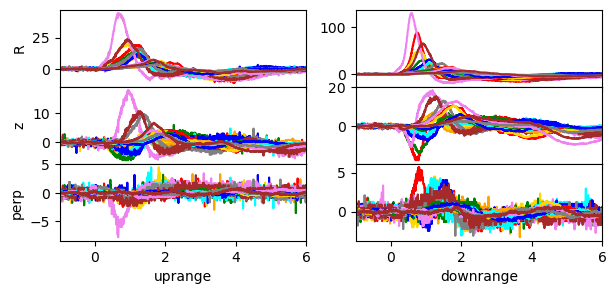

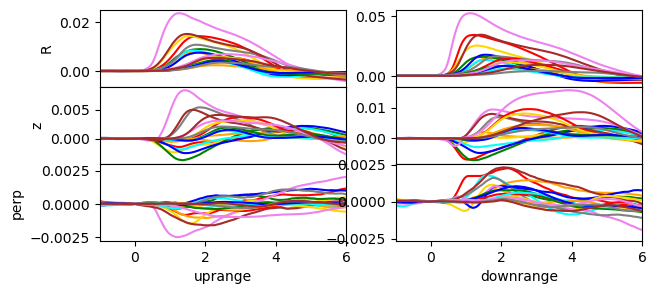

In [38]:
colorlist = ['red','orange','gold','green','cyan','blue','violet','grey','brown']
colorlist = np.append(colorlist,colorlist)
colorlist = np.append(colorlist,colorlist)
display6(adata_cube_uprange_60,adata_cube_downrange_60) # a_R, a_Z up/down range
display6(vdata_cube_uprange_60,vdata_cube_downrange_60) # v_R, v_Z up/down range

In [15]:
#  40 degree impacts 

dfilelist_c  = [
    't64c.csv',
    't65c.csv',
    't66c.csv',
    't67c.csv',
    't68c.csv',
    't69c.csv',
    't70c.csv',
    't71c.csv',
    't72c.csv']
dfilelist_f  = [
    't64f.csv',
    't65f.csv',
    't66f.csv',
    't67f.csv',
    't68f.csv',
    't69f.csv',
    't70f.csv',
    't71f.csv',
    't72f.csv']

t_impact_list_40 = np.array([
    575.9,
    579.0,
    581.8,
    587.7,
    582.9,
    573.0,
    575.1,
    577.3,
    587.7])
    
R_list_40 = R_list_60
z_list_40 = z_list_60
thetalist_40 = z_list_40*0 + 40.0
r_list_40  = r_list_60

data_cube_uprange_c,data_cube_downrange_c = read_data_set(datadir,cal_F1F2,dfilelist_c,t_impact_list_40)
data_cube_uprange_f,data_cube_downrange_f = read_data_set(datadir,cal_F5F7,dfilelist_f,t_impact_list_40)

data_cube_uprange_40   = cat_cf(data_cube_uprange_c,data_cube_uprange_f)
data_cube_downrange_40 = cat_cf(data_cube_downrange_c,data_cube_downrange_f)

adata_cube_uprange_40,   vdata_cube_uprange_40   = mkvels(data_cube_uprange_40,dt)
adata_cube_downrange_40, vdata_cube_downrange_40 = mkvels(data_cube_downrange_40,dt)
u_up_40,u_down_40,utheta_up_40,utheta_down_40,ur_up_40,ur_down_40 = \
    find_peaks_angles(vdata_cube_uprange_40,vdata_cube_downrange_40,R_list_40,z_list_40)
a_up_40,a_down_40,atheta_up_40,atheta_down_40,ar_up_40,ar_down_40 = \
    find_peaks_angles(adata_cube_uprange_40,adata_cube_downrange_40,R_list_40,z_list_40)

In [16]:
#  20 degree impacts 

dfilelist_c  = [
    't73c.csv',
    't74c.csv',
    't75c.csv',
    't76c.csv',
    't77c.csv',
    't78c.csv',
    't79c.csv',
    't80c.csv',
    't81c.csv']
dfilelist_f  = [
    't73f.csv',
    't74f.csv',
    't75f.csv',
    't76f.csv',
    't77f.csv',
    't78f.csv',
    't79f.csv',
    't80f.csv',
    't81f.csv']

t_impact_list_20 = np.array([
    599.8,
    595.7,
    588.8,
    581.3,
    577.6,
    578.9,
    582.1,
    594.7,
    594.4])
     
R_list_20 = R_list_60
z_list_20 = z_list_60
thetalist_20 = z_list_20*0 + 20.0
r_list_20  = r_list_60

data_cube_uprange_c,data_cube_downrange_c = read_data_set(datadir,cal_F1F2,dfilelist_c,t_impact_list_20)
data_cube_uprange_f,data_cube_downrange_f = read_data_set(datadir,cal_F5F7,dfilelist_f,t_impact_list_20)

data_cube_uprange_20 = cat_cf(data_cube_uprange_c,data_cube_uprange_f)
data_cube_downrange_20 = cat_cf(data_cube_downrange_c,data_cube_downrange_f)

adata_cube_uprange_20,   vdata_cube_uprange_20   = mkvels(data_cube_uprange_20,dt)
adata_cube_downrange_20, vdata_cube_downrange_20 = mkvels(data_cube_downrange_20,dt)
u_up_20,u_down_20,utheta_up_20,utheta_down_20,ur_up_20,ur_down_20 = \
    find_peaks_angles(vdata_cube_uprange_20,vdata_cube_downrange_20,R_list_20,z_list_20)
a_up_20,a_down_20,atheta_up_20,atheta_down_20,ar_up_20,ar_down_20 = \
    find_peaks_angles(adata_cube_uprange_20,adata_cube_downrange_20,R_list_20,z_list_20)

In [17]:
#  80 degree impacts 

dfilelist_c  = [
    't42c.csv',
    't43c.csv',
    't85c.csv']
dfilelist_f  = [
    't42f.csv',
    't43f.csv',
    't85f.csv']

t_impact_list_80 = np.array([
    579.2,
    570.5,
    946.7])
     
R_list_80 = np.array([6.0,8.0,6,10,12,10])
z_list_80 = R_list_80*0 + 5.0
thetalist_80 = z_list_20*0 + 80.0
r_list_80  = np.sqrt(R_list_80**2 + z_list_80**2)

data_cube_uprange_c,data_cube_downrange_c = read_data_set(datadir,cal_F1F2,dfilelist_c,t_impact_list_80)
data_cube_uprange_f,data_cube_downrange_f = read_data_set(datadir,cal_F5F7,dfilelist_f,t_impact_list_80)

data_cube_uprange_80 = cat_cf(data_cube_uprange_c,data_cube_uprange_f)
data_cube_downrange_80 = cat_cf(data_cube_downrange_c,data_cube_downrange_f)

adata_cube_uprange_80,   vdata_cube_uprange_80   = mkvels(data_cube_uprange_80,dt)
adata_cube_downrange_80, vdata_cube_downrange_80 = mkvels(data_cube_downrange_80,dt)
u_up_80,u_down_80,utheta_up_80,utheta_down_80,ur_up_80,ur_down_80 = \
    find_peaks_angles(vdata_cube_uprange_80,vdata_cube_downrange_80,R_list_80,z_list_80)
a_up_80,a_down_80,atheta_up_80,atheta_down_80,ar_up_80,ar_down_80 = \
    find_peaks_angles(adata_cube_uprange_80,adata_cube_downrange_80,R_list_80,z_list_80)

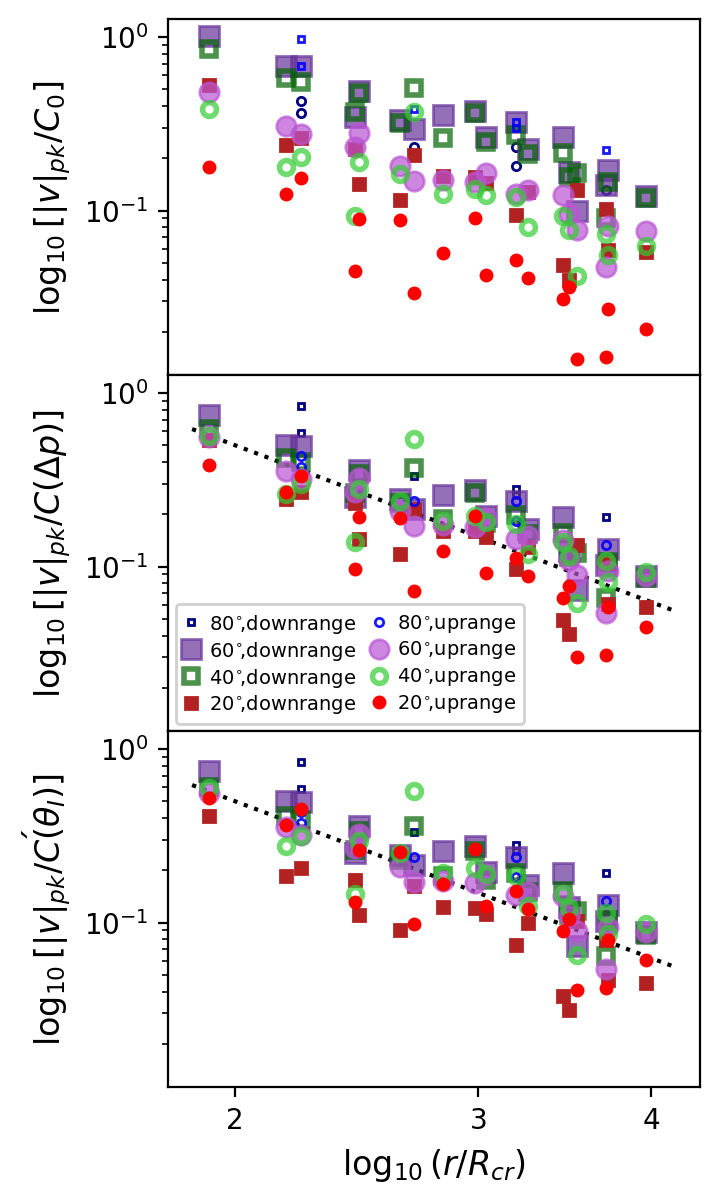

In [42]:
# indexes for dealing with dpx,dpz,Ep fractions of momentum and energy 
i20 = 1
i40 = i20+2
i60 = i20+4
i80 = i20+6

B_eff = 1.0
rhofac = (rho_s*2*np.pi*R_cr**3)
P0 = v_imp*M_p
v_pk_Cr_P = B_eff*P0/rhofac  #Eqn 50 by Q+22 scaling factor here

r_20 = r_list_20/R_cr_cm
r_40 = r_list_40/R_cr_cm
r_60 = r_list_60/R_cr_cm
r_80 = r_list_80/R_cr_cm

up20   = u_up_20/v_pk_Cr_P
up40   = u_up_40/v_pk_Cr_P
up60   = u_up_60/v_pk_Cr_P
up80   = u_up_80/v_pk_Cr_P
down20 = u_down_20/v_pk_Cr_P
down40 = u_down_40/v_pk_Cr_P
down60 = u_down_60/v_pk_Cr_P
down80 = u_down_80/v_pk_Cr_P

fac_arr_u = P_z/rhofac   # renormalization for uprange and downrange, taking into account ricochet
fac_arr_d = (P_z + P_x)/rhofac

fac_arr_u0 = P0_z/rhofac   # renormalization for uprange and downrange, not taking into account ricochet
fac_arr_d0 = (P0_z + P0_x)/rhofac


# do renormalizations
    
down20_corr = u_down_20/fac_arr_d[i20] 
down40_corr = u_down_40/fac_arr_d[i40]
down60_corr = u_down_60/fac_arr_d[i60]
down80_corr = u_down_80/fac_arr_d[i80]
up20_corr   = u_up_20/fac_arr_u[i20]
up40_corr   = u_up_40/fac_arr_u[i40]
up60_corr   = u_up_60/fac_arr_u[i60]
up80_corr   = u_up_80/fac_arr_u[i80]
    
down20_corr0 = u_down_20/fac_arr_d0[i20] 
down40_corr0 = u_down_40/fac_arr_d0[i40]
down60_corr0 = u_down_60/fac_arr_d0[i60]
down80_corr0 = u_down_80/fac_arr_d0[i80]
up20_corr0   = u_up_20/fac_arr_u0[i20]
up40_corr0   = u_up_40/fac_arr_u0[i40]
up60_corr0   = u_up_60/fac_arr_u0[i60]
up80_corr0   = u_up_80/fac_arr_u0[i80]


def plt_rescale3(ofile):
    
    
    fig,axarr = plt.subplots(3,1,facecolor='white',figsize=(3.5,6),dpi=200,sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0.0,wspace=0.,bottom=0.10,top=0.99,right=0.98,left=0.22)
    axarr[2].set_xlabel(r'$\log_{10} (r/R_{cr})$',fontsize=12)

    axarr[0].set_yscale('log')
    axarr[0].set_xscale('log')

    axarr[0].plot(r_80,up80,'o',ms=3,label=r'$80^{\!\circ}\!\!$,uprange',\
             markerfacecolor='none', markeredgewidth=1,color='navy')
    axarr[0].plot(r_60,down60,'s',color='rebeccapurple',ms=7,alpha=0.7,\
                  label=r'$60^{\!\circ}\!\!$,dnrng')         
    axarr[0].plot(r_40,down40,'s',color='darkgreen',ms=5,alpha=0.7,\
             markerfacecolor='none', markeredgewidth=2,label=r'$40^{\!\circ}\!\!$,dnrng')
    axarr[0].plot(r_20,down20,'s',color='firebrick',ms=4,\
                  label=r'$20^{\!\circ}\!\!$,dnrng')

    axarr[0].plot(r_80,down80,'s',ms=2,label=r'$80^{\!\circ}\!\!$,downrange',\
             markerfacecolor='none', markeredgewidth=1,color='blue',alpha=0.9)
    axarr[0].plot(r_60,up60,'o',ms=7,alpha=0.7,color='mediumorchid',\
                  label=r'$60^{\!\circ}\!\!$,uprng')
    axarr[0].plot(r_40,up40,'o',color='limegreen',ms=5,alpha=0.7,\
              markerfacecolor='none', markeredgewidth=2,label=r'$40^{\!\circ}\!\!$,uprng')
    axarr[0].plot(r_20,up20,'ro',ms=4,label=r'$20^{\!\circ}\!\!$,uprng')


    rlog = np.logspace(0.27,0.62,20)  # is r/R_cr
    vfun = 4*rlog**-3  # exponent is here
    axarr[1].plot(rlog,vfun,'k:',lw=1.5)  # dotted black line showing decay 

    axarr[1].plot(r_80,down80_corr,'s',ms=2,label=r'$80^{\!\circ}\!\!$,downrange',\
             markerfacecolor='none', markeredgewidth=1,color='navy')
    axarr[1].plot(r_60,down60_corr,'s',color='rebeccapurple',ms=7,alpha=0.7,\
             label=r'$60^{\!\circ}\!\!$,downrange')
    axarr[1].plot(r_40,down40_corr,'s',color='darkgreen',ms=5,alpha=0.7,\
              markerfacecolor='none', markeredgewidth=2,label=r'$40^{\!\circ}\!\!$,downrange')
    axarr[1].plot(r_20,down20_corr,'s',color='firebrick',ms=4,\
                  label=r'$20^{\!\circ}\!\!$,downrange')

    axarr[1].plot(r_80,up80_corr,'o',ms=3,label=r'$80^{\!\circ}\!\!$,uprange',\
             markerfacecolor='none', markeredgewidth=1,color='blue',alpha=0.9)
    axarr[1].plot(r_60,up60_corr,'o',ms=7,alpha=0.7,color='mediumorchid',\
              label=r'$60^{\!\circ}\!\!$,uprange')
    axarr[1].plot(r_40,up40_corr,'o',color='limegreen',ms=5,alpha=0.7,\
             markerfacecolor='none', markeredgewidth=2,label=r'$40^{\!\circ}\!\!$,uprange')
    axarr[1].plot(r_20,up20_corr,'ro',ms=4,label=r'$20^{\!\circ}\!\!$,uprange')
    
    axarr[2].plot(rlog,vfun,'k:',lw=1.5)  # dotted black line showing decay 

    axarr[2].plot(r_80,down80_corr0,'s',ms=2,label=r'$80^{\!\circ}\!\!$,downrange',\
             markerfacecolor='none', markeredgewidth=1,color='navy')
    axarr[2].plot(r_60,down60_corr0,'s',color='rebeccapurple',ms=7,alpha=0.7,\
             label=r'$60^{\!\circ}\!\!$,downrange')
    axarr[2].plot(r_40,down40_corr0,'s',color='darkgreen',ms=5,alpha=0.7,\
              markerfacecolor='none', markeredgewidth=2,label=r'$40^{\!\circ}\!\!$,downrange')
    axarr[2].plot(r_20,down20_corr0,'s',color='firebrick',ms=4,\
                  label=r'$20^{\!\circ}\!\!$,downrange')

    axarr[2].plot(r_80,up80_corr0,'o',ms=3,label=r'$80^{\!\circ}\!\!$,uprange',\
             markerfacecolor='none', markeredgewidth=1,color='blue',alpha=0.9)
    axarr[2].plot(r_60,up60_corr0,'o',ms=7,alpha=0.7,color='mediumorchid',\
              label=r'$60^{\!\circ}\!\!$,uprange')
    axarr[2].plot(r_40,up40_corr0,'o',color='limegreen',ms=5,alpha=0.7,\
             markerfacecolor='none', markeredgewidth=2,label=r'$40^{\!\circ}\!\!$,uprange')
    axarr[2].plot(r_20,up20_corr0,'ro',ms=4,label=r'$20^{\!\circ}\!\!$,uprange')


    axarr[1].legend(handletextpad=0.5,handlelength=0.8,borderpad=0.4,labelspacing=0.2,fontsize=7,\
                borderaxespad=0.4,columnspacing=0.8,ncols=2,loc='lower left',framealpha=0.9)


    axarr[0].set_ylabel(r'$\log_{10} [|v|_{pk}/C_0]$',fontsize=12)
    axarr[1].set_ylabel(r'$\log_{10} [|v|_{pk}/C(\Delta p)]$',fontsize=12)
    axarr[2].set_ylabel(r'$\log_{10} [|v|_{pk}/C\'(\theta_I)]$',fontsize=12)
    axarr[1].set_xticks([2,3,4],['2','3','4'])
    plt.savefig(ofile,dpi=200)
    #print(up60_corr,up60_corr)
    

    
ofile = 'rescale3.png'; plt_rescale3(ofile)


In [40]:
# look at scatter in these plots!
def getsigs(fac,beta):
    lr = np.log(fac) - beta*np.log(r_20); n = 2*len(lr)
    diff  = np.sum((lr - np.log(down20_corr))**2)
    diff += np.sum((lr - np.log(up20_corr))**2)
    lr = np.log(fac) - beta*np.log(r_40); n+= 2*len(lr)
    diff += np.sum((lr - np.log(down40_corr))**2)
    diff += np.sum((lr - np.log(up40_corr))**2)
    lr = np.log(fac) - beta*np.log(r_60); n+= 2*len(lr)
    diff += np.sum((lr - np.log(down60_corr))**2)
    diff += np.sum((lr - np.log(up60_corr))**2)
    lr = np.log(fac) - beta*np.log(r_80); n+= 2*len(lr)
    diff += np.sum((lr - np.log(down80_corr))**2)
    diff += np.sum((lr - np.log(up80_corr))**2)
    sig = np.sqrt(diff/n)
    #print('sig {:.4f}'.format(sig))
    
    lr = np.log(fac) - beta*np.log(r_20); n = 2*len(lr)
    diff  = np.sum((lr - np.log(down20_corr0))**2)
    diff += np.sum((lr - np.log(up20_corr0))**2)
    lr = np.log(fac) - beta*np.log(r_40); n+= 2*len(lr)
    diff += np.sum((lr - np.log(down40_corr0))**2)
    diff += np.sum((lr - np.log(up40_corr0))**2)
    lr = np.log(fac) - beta*np.log(r_60); n+= 2*len(lr)
    diff += np.sum((lr - np.log(down60_corr0))**2)
    diff += np.sum((lr - np.log(up60_corr0))**2)
    lr = np.log(fac) - beta*np.log(r_80); n+= 2*len(lr)
    diff += np.sum((lr - np.log(down80_corr0))**2)
    diff += np.sum((lr - np.log(up80_corr0))**2)
    sig0 = np.sqrt(diff/n)
    print('fac beta sig sig0 {:.1f} {:.1f} {:.4f} {:.4f}'.format(fac, beta, sig,sig0))
# second sigma is with momentum taking into account only impact angle
# first sigma is taking into account ricochet


for fac in np.arange(3.2,4.8,0.2):
    beta=3.0; 
    getsigs(fac,beta)
print("")

for fac in np.arange(4.2,6.8,0.2):
    beta=3.3; 
    getsigs(fac,beta)
print("")
    
for fac in np.arange(1.2,3.8,0.2):
    beta=2.5; 
    getsigs(fac,beta)



fac beta sig sig0 3.2 3.0 0.4923 0.4993
fac beta sig sig0 3.4 3.0 0.4597 0.4659
fac beta sig sig0 3.6 3.0 0.4345 0.4397
fac beta sig sig0 3.8 3.0 0.4165 0.4207
fac beta sig sig0 4.0 3.0 0.4055 0.4085
fac beta sig sig0 4.2 3.0 0.4008 0.4027
fac beta sig sig0 4.4 3.0 0.4018 0.4026
fac beta sig sig0 4.6 3.0 0.4078 0.4075

fac beta sig sig0 4.2 3.3 0.5323 0.5397
fac beta sig sig0 4.4 3.3 0.5043 0.5112
fac beta sig sig0 4.6 3.3 0.4803 0.4866
fac beta sig sig0 4.8 3.3 0.4601 0.4658
fac beta sig sig0 5.0 3.3 0.4437 0.4487
fac beta sig sig0 5.2 3.3 0.4310 0.4353
fac beta sig sig0 5.4 3.3 0.4219 0.4254
fac beta sig sig0 5.6 3.3 0.4162 0.4188
fac beta sig sig0 5.8 3.3 0.4136 0.4155
fac beta sig sig0 6.0 3.3 0.4140 0.4150
fac beta sig sig0 6.2 3.3 0.4170 0.4172
fac beta sig sig0 6.4 3.3 0.4223 0.4218
fac beta sig sig0 6.6 3.3 0.4296 0.4284

fac beta sig sig0 1.2 2.5 0.8337 0.8431
fac beta sig sig0 1.4 2.5 0.7023 0.7112
fac beta sig sig0 1.6 2.5 0.5972 0.6056
fac beta sig sig0 1.8 2.5 0.5156 0.523

In [ ]:
# sigmas are not significantly different between two types of normalization
# and there is not much difference between exponent of 3 and 2.5